# Imports

In [1]:
import seaborn as sns
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pylab as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet

# Load data

In [2]:
df = pd.read_csv("e-commerce.csv", index_col=0, parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_estimated_delivery_date", "order_delivered_customer_date"])

In [3]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,expected_delivery_timedelta,delivery_time,product_volume,same_city,same_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,SP,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1343007000000000,728920000000000,1976.0,False,True
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,SP,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1056629000000000,245712000000000,1976.0,False,True
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,SP,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1056913000000000,432314000000000,1976.0,False,True
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1,87285b34884572647811a353c7ac498a,...,SP,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1729994000000000,1276693000000000,1976.0,False,False
4,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23,1,b00a32a0b42fd65efb58a5822009f629,...,SP,02c9e0c05a817d4562ec0e8c90f29dba,8577,itaquaquecetuba,SP,1074245000000000,538061000000000,3000.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20,1,31ec3a565e06de4bdf9d2a511b822b4d,...,SP,2077f7ec37df79c62cc24b7b8f30e8c9,8528,ferraz de vasconcelos,SP,1604210000000000,708227000000000,23520.0,False,True
112646,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,1,241a1ffc9cf969b27de6e72301020268,...,SC,78a159045124eb7601951b917a42034f,89111,gaspar,SC,1570104000000000,-9223372036854775808,704.0,False,True
112647,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16,1,1d187e8e7a30417fda31e85679d96f0f,...,SP,8cf3c6e1d2c8afaab2eda3fa01d4e3d2,60455,fortaleza,CE,1952013000000000,824468000000000,19200.0,False,False
112648,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08,1,6e1c2008dea1929b9b6c27fa01381e90,...,SP,e55e436481078787e32349cee9febf5e,39803,teofilo otoni,MG,1392399000000000,1821488000000000,35301.0,False,False


In [4]:
df.order_status.value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [5]:
df[(df.order_id.duplicated())].order_status.value_counts()

delivered      13719
canceled          81
shipped           79
processing        56
invoiced          47
approved           1
unavailable        1
Name: order_status, dtype: int64

# Create time series

Time series is created by converting timestamp value of order purchase.

In [6]:
df2 = df.sort_values(by="order_purchase_timestamp")
df2["date"] = df2["order_purchase_timestamp"].apply(lambda x: x.date())

In [7]:
df2.columns.sort_values()

Index(['customer_city', 'customer_id', 'customer_state', 'customer_unique_id',
       'customer_zip_code_prefix', 'date', 'delivery_time',
       'expected_delivery_timedelta', 'freight_value', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_id', 'order_item_id',
       'order_purchase_timestamp', 'order_status', 'price',
       'product_category_name', 'product_description_lenght',
       'product_height_cm', 'product_id', 'product_length_cm',
       'product_name_lenght', 'product_photos_qty', 'product_volume',
       'product_weight_g', 'product_width_cm', 'same_city', 'same_state',
       'seller_city', 'seller_id', 'seller_state', 'seller_zip_code_prefix',
       'shipping_limit_date'],
      dtype='object')

In [8]:
df2.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,expected_delivery_timedelta,delivery_time,product_volume,same_city,same_state,date
81394,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,1,c1488892604e4ba5cff5b4eb4d595400,...,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,3897881000000000,-9223372036854775808,5376.0,False,False,2016-09-04
81395,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,2,f293394c72c9b5fafd7023301fc21fc2,...,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,3897881000000000,-9223372036854775808,5376.0,False,False,2016-09-04
91998,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,1,f3c2d01a84c947b078e32bbef0718962,...,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,4578266000000000,-9223372036854775808,1250.0,False,False,2016-09-05
103266,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,3,5a6b04657a4c5ee34285d1e4619a96b4,...,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,1597402000000000,4735860000000000,4096.0,False,False,2016-09-15
103265,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,2,5a6b04657a4c5ee34285d1e4619a96b4,...,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,1597402000000000,4735860000000000,4096.0,False,False,2016-09-15


In [9]:
df2["delta"] = (df2["order_delivered_carrier_date"] - df2["order_purchase_timestamp"]) / np.timedelta64(1,'h')

In [10]:
ts5 = df2.set_index("order_purchase_timestamp").resample("1d").mean()

In [11]:
ts5.columns

Index(['order_item_id', 'price', 'freight_value', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'customer_zip_code_prefix',
       'expected_delivery_timedelta', 'delivery_time', 'product_volume',
       'same_city', 'same_state', 'delta'],
      dtype='object')

# Plots and exploratory analysis

Remove beggining of dataset, because there were few too samples to predict on.

In [12]:
ts7 = ts5[ts5.index > "2017-02-01"]

## Plot time series

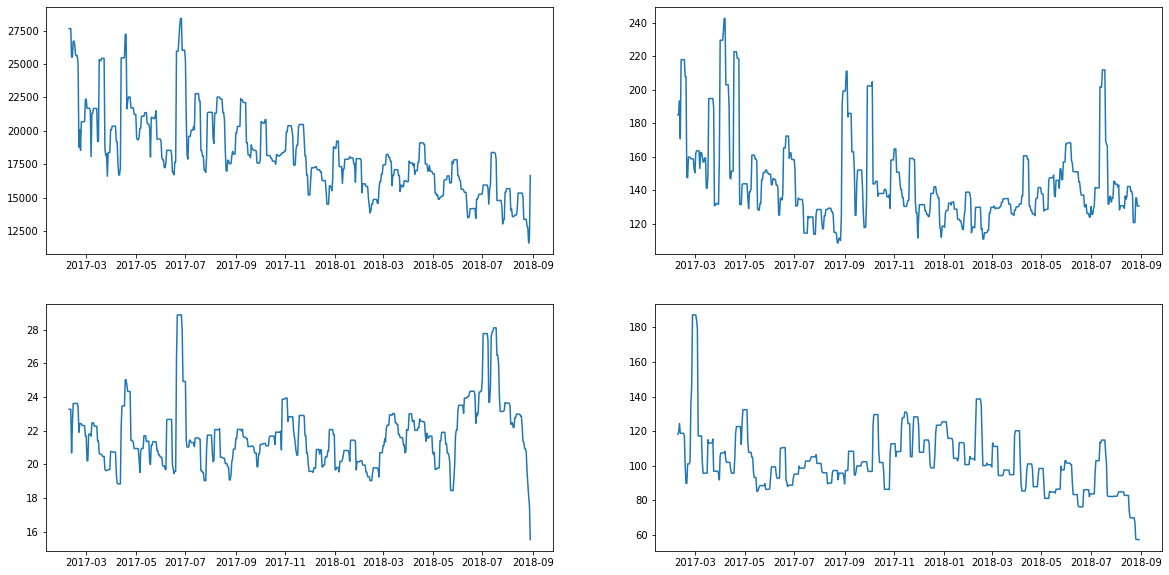

In [18]:
fig, axs = plt.subplots(2,2,figsize=(20,10))

axs[0, 0].plot(ts7.loc[:, "product_volume"].rolling(7).quantile(0.95))
axs[0, 1].plot(ts7.loc[:, "price"].rolling(7).quantile(0.95))

axs[1, 0].plot(ts7.loc[:, "freight_value"].rolling(7).quantile(0.95))
axs[1, 1].plot(ts7.loc[:, "delta"].rolling(7).quantile(0.95))

plt.savefig("img/dataset.png")

## Sample prediction with prophet

Initial log joint probability = -3.19175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       737.607   1.92058e-07       519.732      0.3689           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       737.607   5.91999e-09       512.272      0.3368      0.3368      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


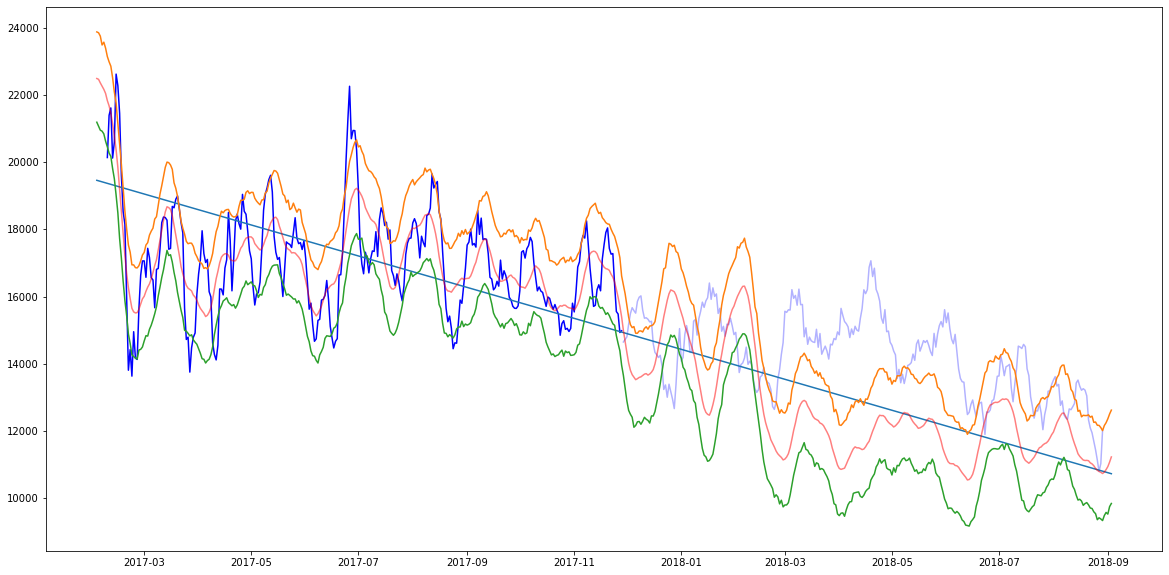

In [16]:
fig = plt.figure(figsize=(20,10))

idx = 300

m = Prophet(daily_seasonality=False,yearly_seasonality=True, seasonality_mode='multiplicative', seasonality_prior_scale=0.02, changepoint_prior_scale=0.01, holidays_prior_scale=0.05)
m.add_seasonality(
    name='monthly', period=30, fourier_order=3, prior_scale=0.1)
data = ts7.loc[:, "product_volume"].rolling(7).mean().reset_index()
data.columns = ["ds","y"]
m.fit(data[:idx])
pred = m.predict(m.make_future_dataframe(periods=len(data)-idx))

plt.plot(data[:idx].ds, data[:idx].y,c='blue')
plt.plot(data[idx:].ds, data[idx:].y, alpha=0.3, c='blue')
plt.plot(pred.ds, pred.trend)
plt.plot(pred.ds, pred.yhat_upper)
plt.plot(pred.ds, pred.yhat_lower)
plt.plot(pred.ds, pred.yhat, color='red', alpha=0.5)
plt.savefig("img/prophet.png")

## Animate predictions over time

In [ ]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(20,10))


def animate(i):
    global m
    idx = 100 + i*5
    ax.clear()

    data = ts7.loc[:, "product_volume"].rolling(3).mean().reset_index()
    data.columns = ["ds","y"]
    m = Prophet(yearly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01, ').fit(data[:idx])
    pred = m.predict(m.make_future_dataframe(periods=len(data)-idx))

    ax.plot(data[:idx].ds, data[:idx].y,c='blue')
    ax.plot(data[idx:].ds, data[idx:].y, alpha=0.3, c='blue')
    ax.plot(pred.ds, pred.trend)
    ax.plot(pred.ds, pred.yhat_upper)
    ax.plot(pred.ds, pred.yhat_lower)
    ax.set_ylim(5000, 40000)
    
anim = animation.FuncAnimation(fig, animate, frames=range(30,90) , interval=20)
writervideo = animation.FFMpegWriter(fps=12)
anim.save('basic_animation.mp4', writer=writervideo)
plt.close()